In [120]:
#Plotting scatter of band angle and prediction error

import ase
from ase import io
from ase.geometry.analysis import Analysis

import rascal
from rascal.representations import SphericalInvariants as SOAP

import ase
from ase import io
#from ase import atoms

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

import soprano
from soprano.properties.nmr import *

import random

import soprano
from soprano.properties.nmr import *

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from numpy.linalg import lstsq

import pandas as pd
from pandas import DataFrame
import utils

import itertools


In [121]:
def keys_grabber(category):
    keys = list(pickle.load(open('Data/' + category + '/uid_index.pkl','rb')).keys())
    for i in keys:
        if not os.path.exists('Data/'+category+'/' + str(i) + '.magres'):
            keys.remove(i)
    return keys

def descriptor(cut, smooth):
    HYPERS = {
    'soap_type': 'PowerSpectrum',
    'interaction_cutoff': cut,
    'max_radial': 2,
    'max_angular': 6,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': smooth,
    'radial_basis': 'GTO',
    'inversion_symmetry': True,
    'normalize' : True
    }
    soap = SOAP(**HYPERS)
    return soap


def puller(keys, soap, category):
    #reading in all structures and creating all spectrums.
    for i in keys:
        #print(i)
        if keys.index(i) == 0:
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.magres')
            spectrum = soap.transform(structure).get_features(soap)
            full_spec = spectrum
            iso = MSIsotropy.get(structure)
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.castep')
            force = np.array(list(map(np.linalg.norm, structure.get_forces())))
        else:
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.magres')
            spectrum = soap.transform(structure).get_features(soap)
            full_spec = np.concatenate((full_spec,spectrum),axis =0)
            iso = np.concatenate((iso,MSIsotropy.get(structure)),axis=0)
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.castep')
            temp = np.array(list(map(np.linalg.norm, structure.get_forces())))
            force = np.concatenate((force,temp), axis=0)

    return full_spec, iso, force


def splitter(tr_f, no_sparse, full_spec, iso, force):
    #Randomly choosing representative matrix
    ids = range(len(full_spec)) #list of all ids
    tr_id = random.sample(ids, int(tr_f*len(full_spec)))
    sp_id = random.sample(tr_id, no_sparse)

    tr_sp = full_spec[tr_id] #training spectrums
    sp_sp = full_spec[sp_id] #representative/sparse spectrums

    tr_ta = iso[tr_id] #training target
    
    te_id = list(ids)
    for i in tr_id:
        te_id.remove(i)
    te_sp = full_spec[te_id]
    te_ta = iso[te_id]
    
    te_fo = force[te_id]
    
    return sp_sp, tr_sp, tr_ta, te_sp, te_ta, te_fo, te_id 
    
    
def kerneller(to_kernel, sp_sp, ker_exp):
    kernel = (to_kernel@sp_sp.T)**ker_exp
    return kernel

In [122]:
def model_accuracy(cat, cut, smo_cut, sp_size, ker_exp, reg):

    keys = keys_grabber(cat)
    #keys = [2]
    soap = descriptor(cut, smo_cut)
    full_spec, iso, force = puller(keys, soap, cat)
    
    sp_sp, tr_sp, tr_ta, te_sp, te_ta, te_fo, te_id = splitter(0.9, sp_size, full_spec, iso, force)
    
    KNM = kerneller(tr_sp, sp_sp, ker_exp)
    KMM = kerneller(sp_sp, sp_sp, ker_exp)
    KTM = kerneller(te_sp, sp_sp, ker_exp)
    res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
    c = res[0]
    pred = KTM @ c
    rmse = mean_squared_error(te_ta, pred, squared=False)

    
    return te_ta, pred, rmse, te_fo, te_id, keys

In [136]:
#Rattle - Forces
cut = 3.5
smo_cut = 1
sp_size = 1000
ker_exp = 20
reg = 1*10**-8

te_ta, predicted, rmse, te_fo, te_id, keys = model_accuracy('MD_Distorted', cut, smo_cut, sp_size, ker_exp, reg)
print(rmse)

/home/turner/.local/lib/python3.8/site-packages/ase/calculators/castep.py:1460: UserWarning: Could not load .bands file, eigenvalues and Fermi energy are unknown
  warnings.warn('Could not load .bands file, eigenvalues and '


2.725463063649191


In [138]:
df = pd.DataFrame()
df['target'] = te_ta
df['predicted'] = predicted
df['error'] = df['target']  - df['predicted']
df.to_csv('MD_raw_data.csv')

In [116]:
#Extract angles in two ways for all structures and modify ids to be 

from ase.geometry.analysis import Analysis

at_tot = 0
si_o_si_id_mas = []
si_o_si_ang_mas = []

o_si_o_id_mas = []
o_si_o_ang_mas = []

for i in keys:
    struc = ase.io.read('Data/AM300K/'+str(i)+'.castep')
    no_at = len(struc.get_positions())
    
    ana = Analysis(struc)
    
    si_o_si_id = ana.get_angles('Si','O','Si')
    si_o_si_ang = ana.get_values(si_o_si_id)
    
    o_si_o_id = ana.get_angles('O','Si','O')
    o_si_o_ang = ana.get_values(o_si_o_id)
    
    for l in si_o_si_id[0]:
        si_o_si_id_mas.append((l[0]+at_tot,l[1]+at_tot,l[2]+at_tot))
        
    for l in o_si_o_id[0]:
        o_si_o_id_mas.append((l[0]+at_tot,l[1]+at_tot,l[2]+at_tot))
    
    for l in o_si_o_ang[0]:
        o_si_o_ang_mas.append(l)
        
    for l in si_o_si_ang[0]:
        si_o_si_ang_mas.append(l)

    at_tot += no_at
    
    

/home/turner/.local/lib/python3.8/site-packages/ase/calculators/castep.py:1460: UserWarning: Could not load .bands file, eigenvalues and Fermi energy are unknown
  warnings.warn('Could not load .bands file, eigenvalues and '


In [117]:

tup_id = {}


for i in range(len(o_si_o_id_mas)):
    if list(zip(*o_si_o_id_mas))[1][i] in te_id:
        tup_id[i] = list(zip(*o_si_o_id_mas))[1][i]
        
        
o_ang_te = np.array(o_si_o_ang_mas)[list(tup_id.keys())] #getting angles from tup ids

error = abs(np.array(te_ta) - np.array(predicted))

error_map = list(zip(te_id, error))
error_out = []


for i in list(tup_id.values()):
    for l in error_map:
        if i in l:
            error_out.append(l[1])


df = pd.DataFrame()
df['angle'] = o_ang_te
df['Error'] = error_out


In [119]:
df.to_csv('AM300K_error_angle_o_si_o.csv')

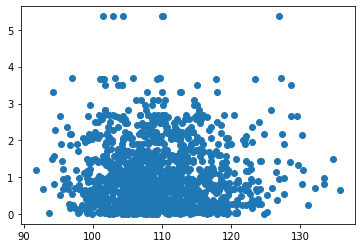

In [118]:
plt.scatter(o_ang_te, error_out)